In [65]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import sys
import random
from torchvision import transforms  
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import KFold 

In [34]:
tumor = []
healthy = []
for f in glob.iglob("./data/Brain_Tumor_Dataset/Positive/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("./data/Brain_Tumor_Dataset/Negative/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [35]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [36]:
tumor.shape

(3266, 128, 128, 3)

In [37]:
healthy.shape

(2000, 128, 128, 3)

In [38]:
np.random.choice(10, 5, replace=False)

array([4, 8, 5, 3, 7])

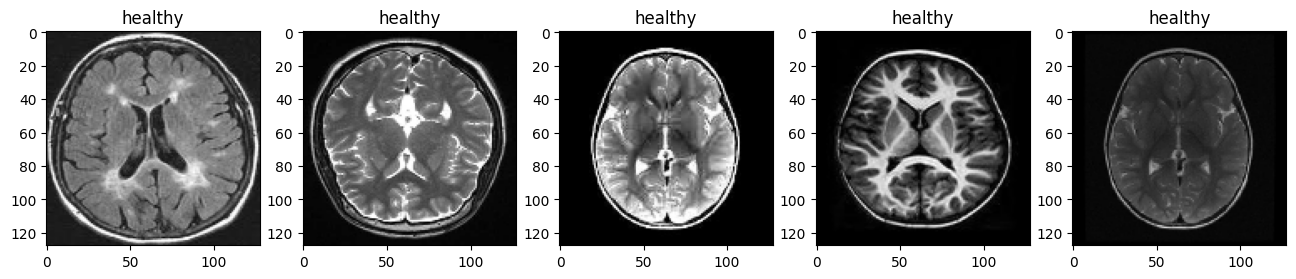

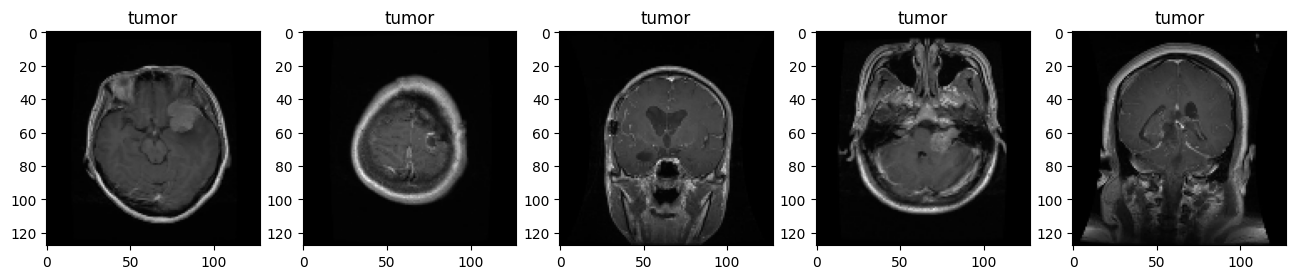

In [39]:
#Visualise MRI images
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

plot_random(healthy, tumor, num=5)

In [40]:
#Torch Dataset Class
class Dataset(object):

    def __len__(self):
        raise NotImplementedError

    def __getitem__(self, index):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [41]:
#Define MRI custom dataset class
class MRIDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        self.tumor = []
        self.healthy = []
        
        #Load tumor images
        for f in glob.iglob(f"{data_path}/Positive/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            self.tumor.append(img)

        #Load healthy images
        for f in glob.iglob(f"{data_path}/Negative/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            self.healthy.append(img)
        
    def __len__(self):
        return len(self.tumor) + len(self.healthy)
    
    def __getitem__(self, index):
        if index < len(self.tumor):
            img = self.tumor[index]
            label = 1  #Tumor
        else:
            img = self.healthy[index - len(self.tumor)]
            label = 0  #Healthy
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

#Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [42]:
#Data loader
data_path = "./data/Brain_Tumor_Dataset"
dataset = MRIDataset(data_path, transform=transform)
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [43]:
#CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Dropout(0.5),  
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Dropout(0.5),  
            nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = torch.sigmoid(x)
        return x

In [44]:
#Cuda if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#CPU tensor
cpu_tensor = torch.rand(10).to(device)
#Moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.1487, 0.2073, 0.9385, 0.3960, 0.8152, 0.2548, 0.6419, 0.7270, 0.0293,
        0.5137], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.1487, 0.2073, 0.9385, 0.3960, 0.8152, 0.2548, 0.6419, 0.7270, 0.0293,
        0.5137], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([2.2118e-02, 4.2968e-02, 8.8073e-01, 1.5679e-01, 6.6456e-01, 6.4901e-02,
        4.1207e-01, 5.2850e-01, 8.5770e-04, 2.6386e-01], device='cuda:0')


In [45]:
#Evaluate model
model = CNN().to(device)

dataset = MRIDataset(data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for image, label in dataloader:
        image = image.to(device)
        label = label.to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [46]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [47]:
accuracy_score(y_true, threshold(outputs))

0.6312191416635017

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

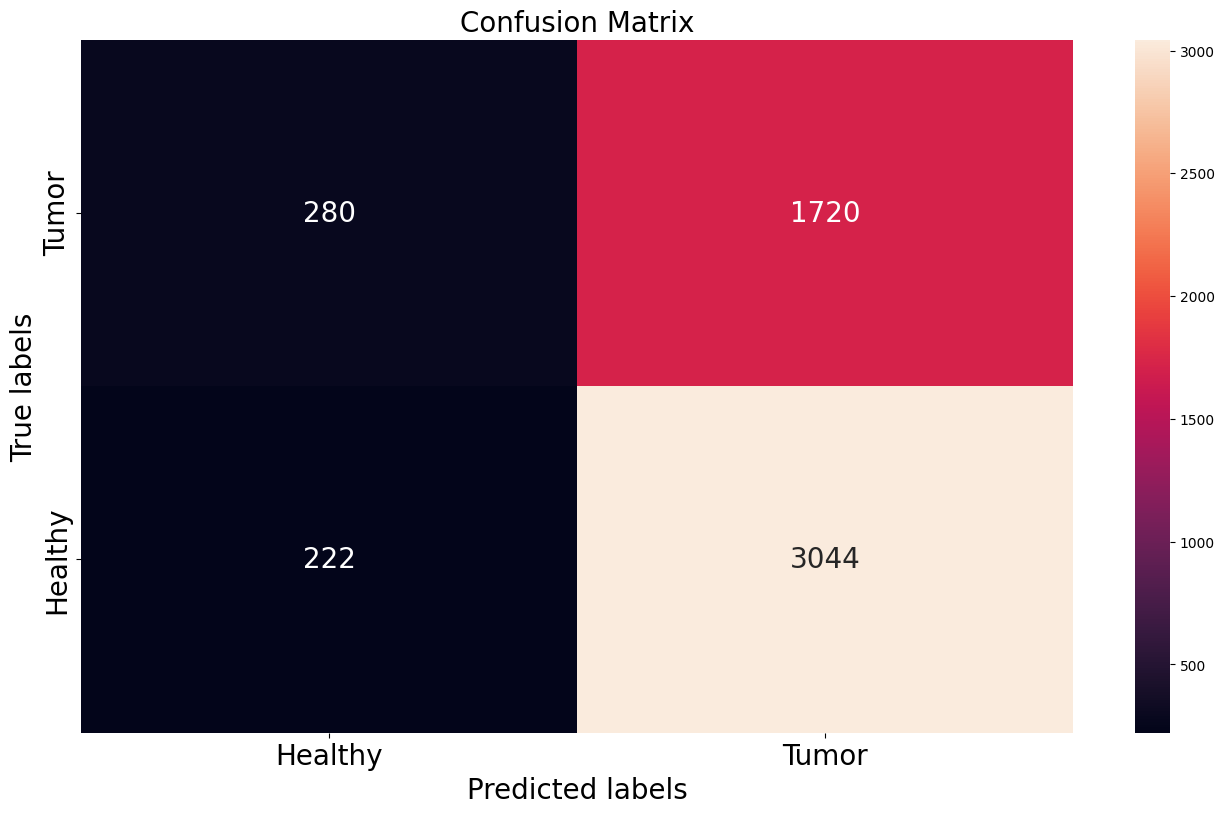

In [48]:
plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

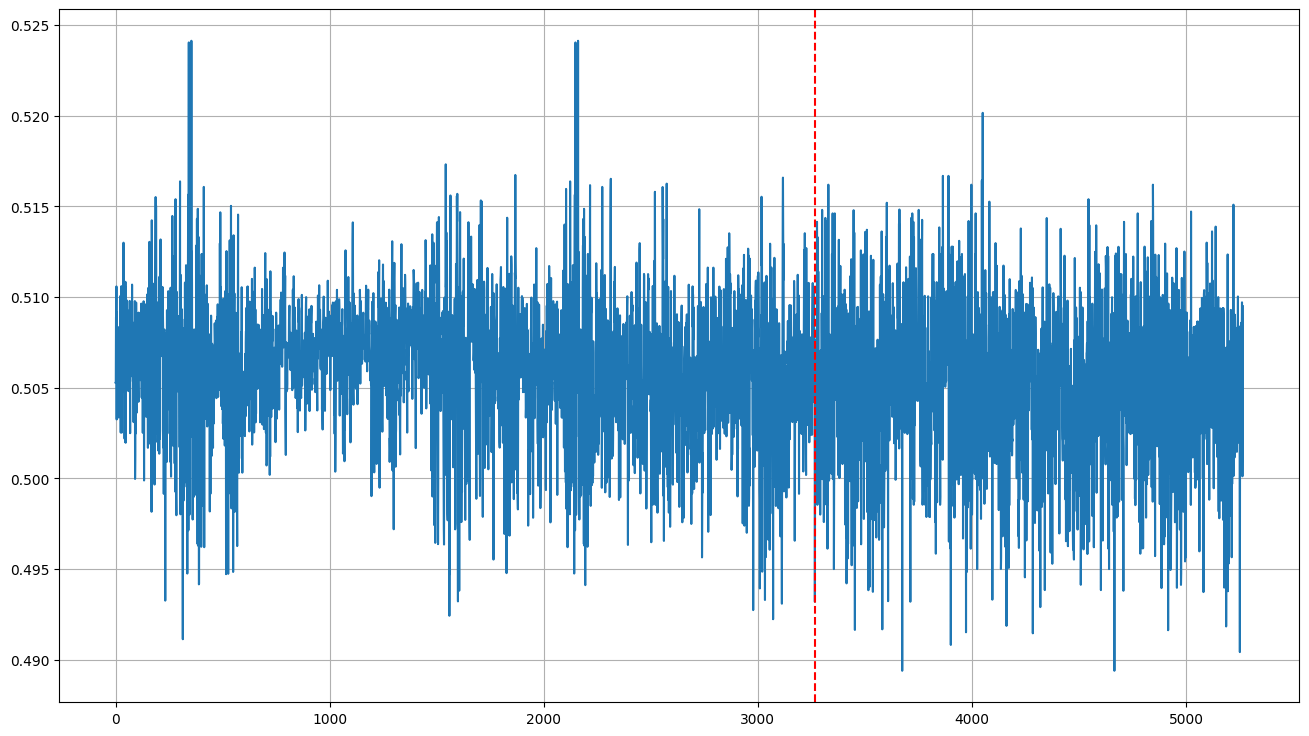

In [49]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [50]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataset = MRIDataset(data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [51]:
for epoch in range(1, EPOCH):
    losses = []
    for data, label in dataloader:  
        optimizer.zero_grad()
        data = data.to(device)
        label = label.float().to(device)  #Convert label to float
        y_hat = model(data)
        #Define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.290355
Train Epoch: 20	Loss: 0.215743
Train Epoch: 30	Loss: 0.169498
Train Epoch: 40	Loss: 0.147064
Train Epoch: 50	Loss: 0.122155
Train Epoch: 60	Loss: 0.107642
Train Epoch: 70	Loss: 0.093039
Train Epoch: 80	Loss: 0.084298
Train Epoch: 90	Loss: 0.064944
Train Epoch: 100	Loss: 0.057285
Train Epoch: 110	Loss: 0.049978
Train Epoch: 120	Loss: 0.048292
Train Epoch: 130	Loss: 0.038675
Train Epoch: 140	Loss: 0.030411
Train Epoch: 150	Loss: 0.021482
Train Epoch: 160	Loss: 0.016343
Train Epoch: 170	Loss: 0.014048
Train Epoch: 180	Loss: 0.007124
Train Epoch: 190	Loss: 0.008016
Train Epoch: 200	Loss: 0.007545
Train Epoch: 210	Loss: 0.001600
Train Epoch: 220	Loss: 0.012243
Train Epoch: 230	Loss: 0.003565
Train Epoch: 240	Loss: 0.003644
Train Epoch: 250	Loss: 0.002553
Train Epoch: 260	Loss: 0.004547
Train Epoch: 270	Loss: 0.006861
Train Epoch: 280	Loss: 0.001602
Train Epoch: 290	Loss: 0.001457
Train Epoch: 300	Loss: 0.004175
Train Epoch: 310	Loss: 0.000540
Train Epoch: 320	

In [52]:
model.eval()
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)  
outputs=[]
y_true = []
with torch.no_grad():
    for data, label in dataloader:
        image = data.to(device)
        label = label.to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

In [53]:
accuracy_score(y_true, threshold(outputs))

1.0

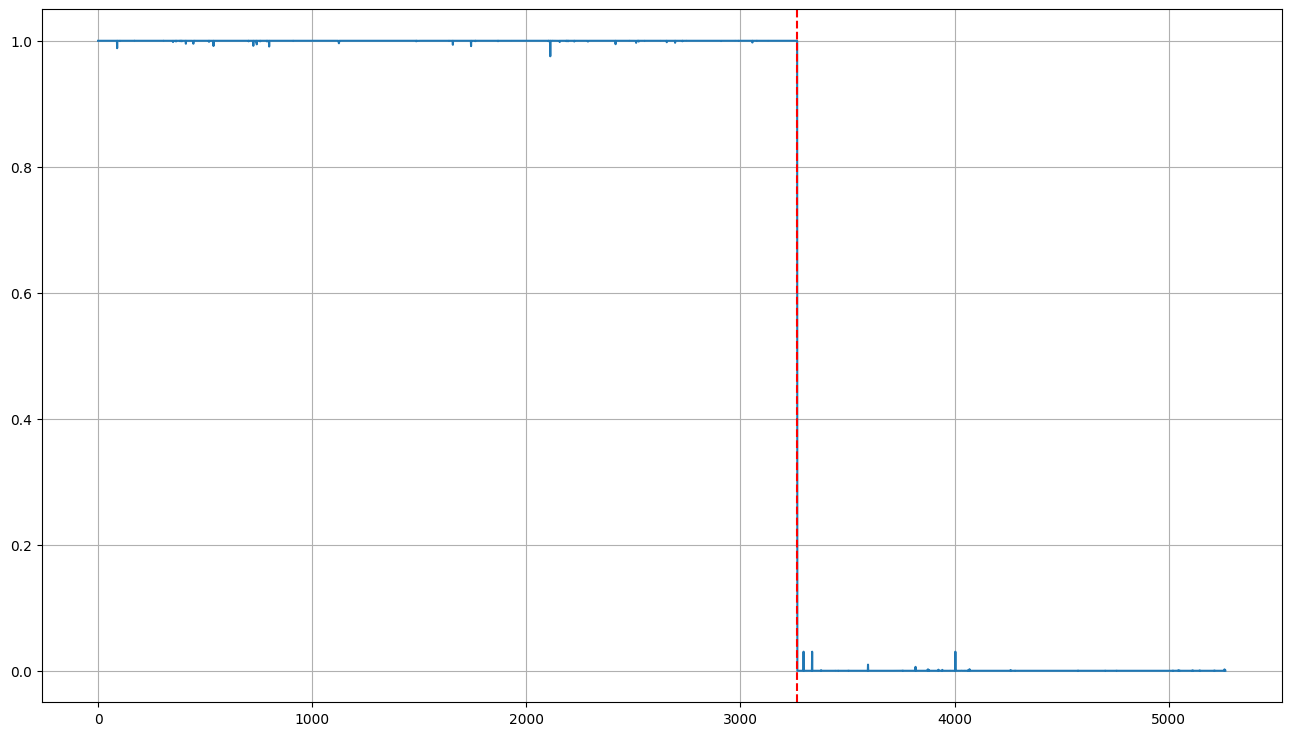

In [54]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

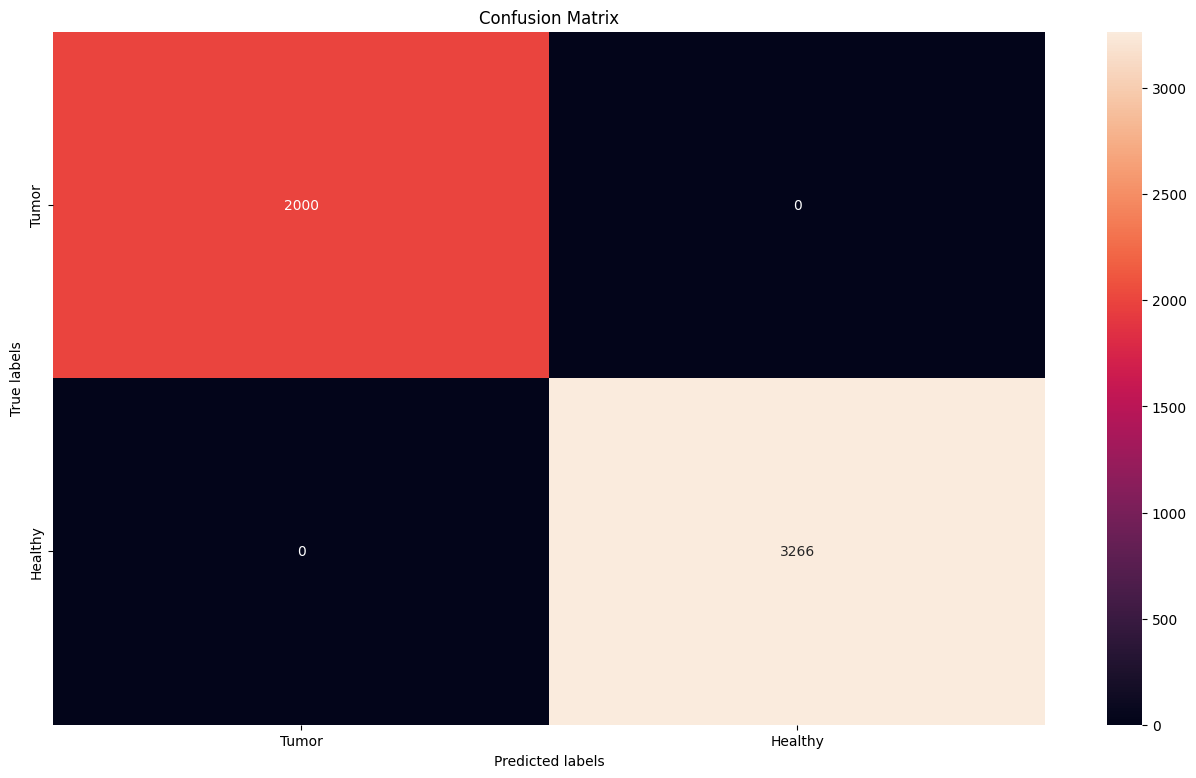

In [55]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

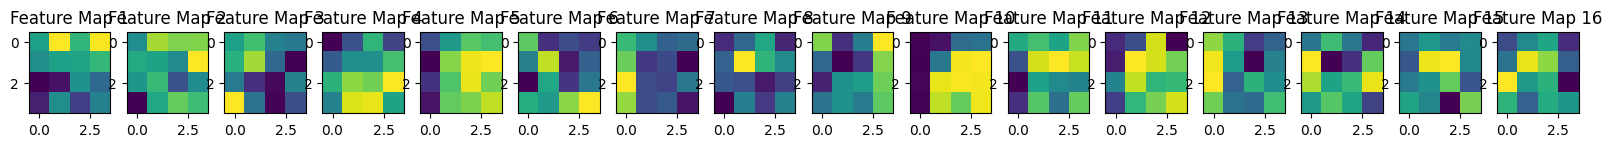

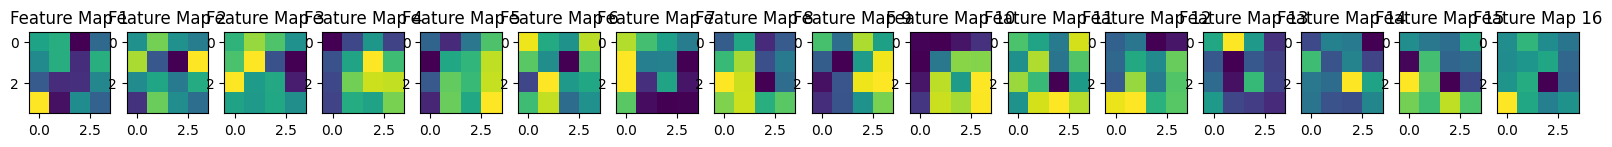

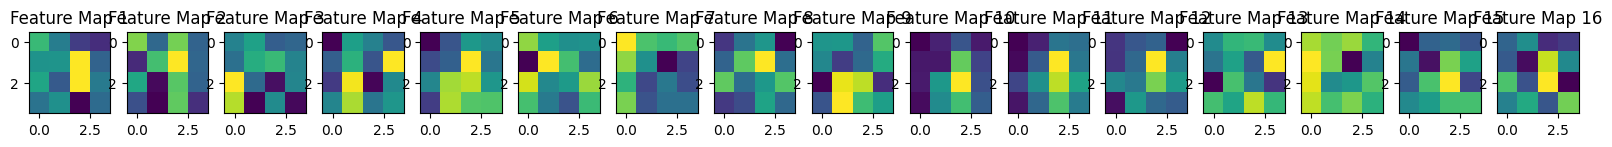

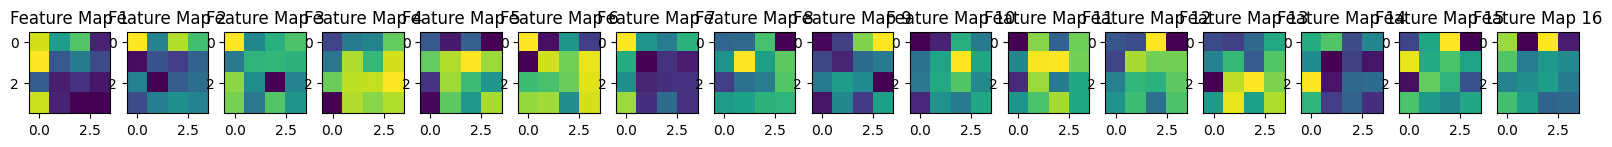

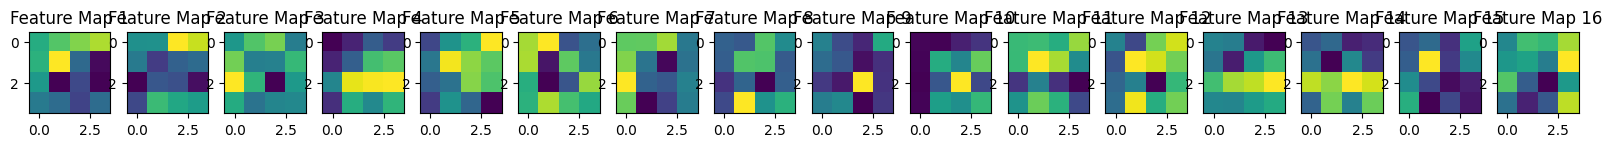

In [56]:
#Visualising the Feature Maps of the Convolutional Filters
def visualize_feature_maps(model, data_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            feature_maps = model.cnn_model(images)
            for i in range(num_images):
                plt.figure(figsize=(20, 10))
                for j in range(len(feature_maps[i])):
                    plt.subplot(1, len(feature_maps[i]), j + 1)
                    plt.imshow(feature_maps[i][j].cpu().detach().numpy(), cmap='viridis')
                    plt.title(f'Feature Map {j+1}')
                plt.show()
            break  # Stop after visualizing feature maps for `num_images` samples

visualize_feature_maps(model, data_loader, device)

In [57]:
#Split Data into Train and Validation Sets
def train_val_split(dataset, validation_split=0.2, shuffle=True, random_seed=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    return train_sampler, val_sampler

# Usage:
train_sampler, val_sampler = train_val_split(dataset)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [58]:
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [59]:
#Split data into train and validation sets using k-fold cross-validation
def k_fold_split(dataset, num_splits=5, random_seed=42):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=random_seed)
    indices = np.arange(len(dataset))
    for train_indices, val_indices in kf.split(indices):
        yield train_indices, val_indices

In [69]:
epoch_train_loss = []
test_accuracys = []

In [60]:
def train_model_with_k_fold(model, dataset, num_epochs=400, num_splits=5, batch_size=32, eta=0.0001, device='cuda'):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    model.to(device)
    train_acc_history = []
    val_acc_history = []
    for fold, (train_indices, val_indices) in enumerate(k_fold_split(dataset, num_splits)):
        print(f'Fold {fold + 1}:')
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
        
        fold_train_acc_history = []
        fold_val_acc_history = []
        for epoch in range(1, num_epochs + 1):
            model.train()
            train_losses = []
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            
            # Training accuracy
            train_accuracy = test_model(model, train_loader, device)
            fold_train_acc_history.append(train_accuracy)
            
            # Validation accuracy
            val_accuracy = test_model(model, val_loader, device)
            fold_val_acc_history.append(val_accuracy)
        
        train_acc_history.append(fold_train_acc_history)
        val_acc_history.append(fold_val_acc_history)
        
        print(f'Validation Accuracy: {val_accuracy}')

    return train_acc_history, val_acc_history

In [61]:
#Test model
def test_model(model, test_loader, device):
    model.eval()
    outputs = []
    labels = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            outputs.extend(output.cpu().numpy())
            labels.extend(targets.cpu().numpy())
    outputs = np.array(outputs).squeeze()
    labels = np.array(labels).squeeze()
    accuracy = accuracy_score(labels, np.where(outputs >= 0.5, 1, 0))
    return accuracy

data_path = "./data/Brain_Tumor_Dataset"
dataset = MRIDataset(data_path, transform=transform)
model = CNN()
train_model_with_k_fold(model, dataset)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
test_accuracy = test_model(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy}')

Fold 1:
Epoch 1/400, Train Loss: 0.5833465549530406
Epoch 2/400, Train Loss: 0.4908877672119574
Epoch 3/400, Train Loss: 0.4686201090614001
Epoch 4/400, Train Loss: 0.44932591294248897
Epoch 5/400, Train Loss: 0.42988786112630006
Epoch 6/400, Train Loss: 0.4070738001980565
Epoch 7/400, Train Loss: 0.38291568873506604
Epoch 8/400, Train Loss: 0.36080072696010274
Epoch 9/400, Train Loss: 0.34895522813453816
Epoch 10/400, Train Loss: 0.33259248011039966
Epoch 11/400, Train Loss: 0.3156804019077258
Epoch 12/400, Train Loss: 0.3048546016780716
Epoch 13/400, Train Loss: 0.29570880701596086
Epoch 14/400, Train Loss: 0.2830881518735127
Epoch 15/400, Train Loss: 0.27773476770204125
Epoch 16/400, Train Loss: 0.26521474907569814
Epoch 17/400, Train Loss: 0.26512307278586156
Epoch 18/400, Train Loss: 0.2619597217011632
Epoch 19/400, Train Loss: 0.24986044289262005
Epoch 20/400, Train Loss: 0.24877375832787066
Epoch 21/400, Train Loss: 0.24238899829938557
Epoch 22/400, Train Loss: 0.241535118583476

In [71]:
# Split data into train and validation sets using k-fold cross-validation
def k_fold_split(dataset, num_splits=5, random_seed=42):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=random_seed)
    indices = np.arange(len(dataset))
    for train_indices, val_indices in kf.split(indices):
        yield train_indices, val_indices

# Create model instance
model = CNN()

# Train model with k-fold cross-validation
train_acc_history, val_acc_history = train_model_with_k_fold(model, dataset)

Fold 1:
Epoch 1/400, Train Loss: 0.5809629758199056
Epoch 2/400, Train Loss: 0.4888600621259574
Epoch 3/400, Train Loss: 0.463323609847011
Epoch 4/400, Train Loss: 0.44395377057971375
Epoch 5/400, Train Loss: 0.42154209327065584
Epoch 6/400, Train Loss: 0.39994182686011
Epoch 7/400, Train Loss: 0.3785005162159602
Epoch 8/400, Train Loss: 0.36047923350424477
Epoch 9/400, Train Loss: 0.34116387220494676
Epoch 10/400, Train Loss: 0.32590506485465803
Epoch 11/400, Train Loss: 0.3110339343547821
Epoch 12/400, Train Loss: 0.304216226732189
Epoch 13/400, Train Loss: 0.29358619603921066
Epoch 14/400, Train Loss: 0.28529178441473935
Epoch 15/400, Train Loss: 0.2740111743861979
Epoch 16/400, Train Loss: 0.2708781815952424
Epoch 17/400, Train Loss: 0.26087641642626486
Epoch 18/400, Train Loss: 0.260898291726004
Epoch 19/400, Train Loss: 0.2519535351770394
Epoch 20/400, Train Loss: 0.24713373353535478
Epoch 21/400, Train Loss: 0.24451935308223421
Epoch 22/400, Train Loss: 0.23909346491211292
Epoch

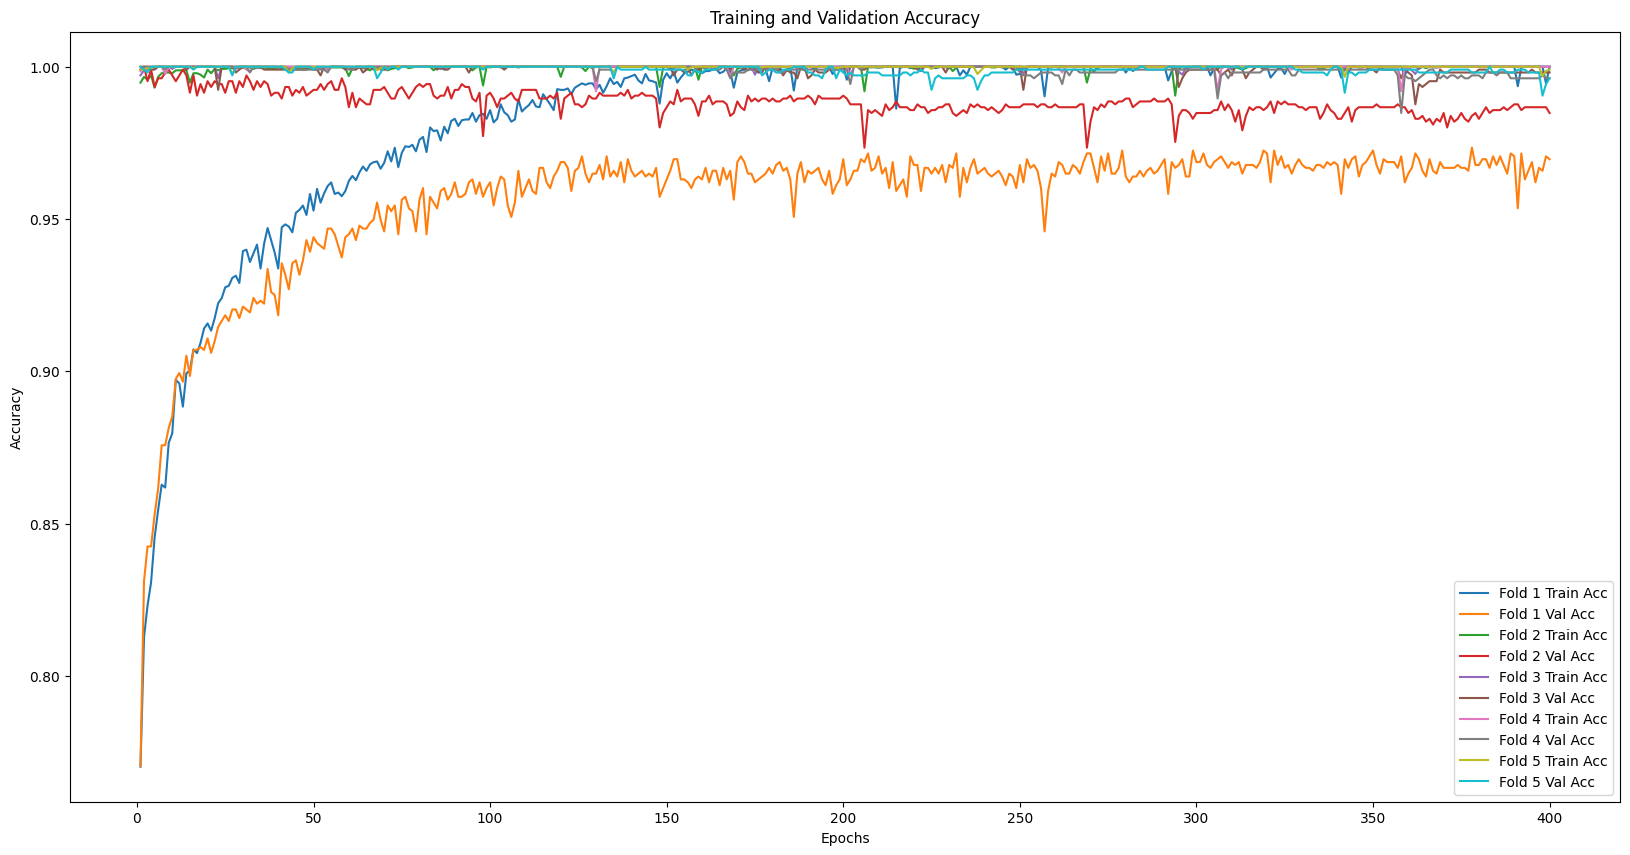

In [73]:
plt.figure(figsize=(20, 10))
for fold in range(len(train_acc_history)):
    plt.plot(range(1, len(train_acc_history[fold]) + 1), train_acc_history[fold], label=f'Fold {fold + 1} Train Acc')
    plt.plot(range(1, len(val_acc_history[fold]) + 1), val_acc_history[fold], label=f'Fold {fold + 1} Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()